<center><h1> Data Camp Project</h1> </center>
<center><h1>Bicycle surplus prediction</h1></center>
<center> <h4>Authors : Ghassen Ben Hassine, Firas Rhimi, Etienne Lenaour, Ryme Kabak, Elyes Karray, Mehdi Bennaceur</h4></center>


<div style="text-align: center;">

<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<center>
<img border="0" src="https://miro.medium.com/max/4096/1*GJ45uUnc49T-D5LdYn7CfQ.jpeg" width="100%"> </td>
</center>

  </tr>
</table> 
</div>



## Table of Contents

0. [Introduction](#Introduction)
1. [Business Motivation](#Business-Motivation)
2. [Data Construction](#Data)
3. [Evaluation metric](#Evaluation-metric)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Feature Engineering](#Feature-Engineering)
6. [Predictions](#Predictions)

# Introduction

New York Bike Sharing system provides a carbon-free way of transportation to more than 50 millions person each month. More than 800 hundreds bike docking stations are available across the city and are open 24/7. It was in part conceived to decrease traffic and usage in other public transport services (subway etc...).


There are two main dataset we will use:

* `bike_data.csv` - bike usage in NYC.
* `weather_data.csv` -  weather data in NYC.

The goal here will be to come up with an algorithm that tells us when and where CitiBike should recharge/discharge a docking station.

# Business Motivation 


# Data  


As stated before, we will be working with two datasets : 
## bike_data.csv
This dataset was built from an extract of https://www.citibikenyc.com/system-data. It includes historical data of bike trips in NYC between 2016 and 2018 : 
* `Trip Duration` - the duration of the trip in seconds
* `Start Time` -Start Date and Time 
* `Stop Time` - Stop Date and Time 
* `Start Station ID` 
* `Start Station Name`
* `Start Station Longitude` - Spatial Coordinates
* `Start Station Latitude` - Spatial Coordinates
* `End Station ID` 
* `End Station Name`
* `End Station Longitude` - Spatial Coordinates
* `End Station Latitude` - Spatial Coordinates
* `Bike ID` 
* `User Type` - Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member
* `Birth Year` - Birth Year of the customer
* `Gender` - Gender of the customer : Zero=unknown; 1=male; 2=female

In [27]:
# Imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap

In [2]:
from get_data import *
raw_data= get_bike_data()
raw_data.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,364,2017-09-01 00:02:01,2017-09-01 00:08:05,3183,Exchange Place,40.716247,-74.033459,3276,Marin Light Rail,40.714584,-74.042817,29670,Subscriber,1989.0,1
1,357,2017-09-01 00:08:12,2017-09-01 00:14:09,3187,Warren St,40.721124,-74.038051,3199,Newport Pkwy,40.728745,-74.032108,26163,Subscriber,1980.0,1
2,432,2017-09-01 00:10:12,2017-09-01 00:17:24,3195,Sip Ave,40.730743,-74.063784,3280,Astor Place,40.719282,-74.071262,26273,Subscriber,1988.0,1
3,934,2017-09-01 00:10:11,2017-09-01 00:25:46,3272,Jersey & 3rd,40.723332,-74.045953,3207,Oakland Ave,40.737604,-74.052478,26297,Subscriber,1991.0,1
4,932,2017-09-01 00:10:16,2017-09-01 00:25:48,3272,Jersey & 3rd,40.723332,-74.045953,3207,Oakland Ave,40.737604,-74.052478,29247,Subscriber,1993.0,2


From this raw dataset, we construct a new dataset that will be used in the challenge as a training set. This new dataset will include : 
* `Year` 
* `Month` 
* `Day` 
* `Hour` 
* `Station ID` 
* `Station Name`
* `Longitude` 
* `Latitude` 
* `Surplus` : The target we want to predict : the difference between the number of bikes that come in a given station and the number of bikes that leave this station in a given date.

The preprocessing to get the train set is done in the get_data.py file. 


In [3]:
train_data = get_flow_data(raw_data)
train_data.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,1.0
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,0.0
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,2.0
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,-1.0
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,2.0


In [4]:
import json
stations_path = 'Data/stations.json'
with open(stations_path, 'r') as f:
    stations_with_capacities = json.load(f)

u = 51
stations = list(stations_with_capacities.keys())

train_data = train_data.loc[train_data['Station Name'].isin(stations)]
train_data.loc[train_data['Station Name'] == stations[u]]

station_surpluses = train_data.loc[train_data['Station Name'] == stations[u]]['Surplus']
print(f'max surplus {max(station_surpluses)}, min surplus {min(station_surpluses)}, capacity {stations_with_capacities[stations[u]]}')

train_data['Current Load'] = train_data.groupby('Station Name').cumsum()['Surplus']
station_loads = train_data.loc[train_data['Station Name'] == stations[u]]['Current Load'] 
print(f'max load {max(station_loads)}, min load {min(station_loads)}, capacity {stations_with_capacities[stations[u]]}')

# max(train_data.loc[train_data['Station Name'] == stations[51]]['Surplus'])
# stations_with_capacities[stations[51]]

max surplus 10.0, min surplus -9.0, capacity 14
max load 4075.0, min load -296.0, capacity 14


## Weather_data.csv


In [5]:
Weather = pd.read_csv("Data/Weather Data/Train_Weather.csv")
Weather.head()

,Hour,Temperature,Apparent Temperature,Wind,Relative Humidity,Date
0,00:51,6°C,4°C,Variable à 7 Km/h,49%,2016-01-01
1,01:51,5°C,4°C,Variable à 6 Km/h,53%,2016-01-01
2,02:51,5°C,3°C,280°7 Km/h,57%,2016-01-01
3,03:51,5°C,2°C,280°15 Km/h,57%,2016-01-01
4,04:51,4°C,0°C,270°17 Km/h,61%,2016-01-01


# Evaluation metric

The idea is not to penalize in the same way a prediction of a higher surplus than the true one and the prediction of a lower surplus than the true one. We may define the loss as follows(called Pinball loss) : 


$l(y_{true},y_{pred})= max(-(1-\tau)(y_{pred}-y_{true}),\tau (y_{pred}-y_{true})) = \begin{cases} \tau(y_{pred}-y_{true}) & \text{if } y_{pred} \geq y_{true} \\  -(1-\tau)(y_{pred}-y_{true}) & \text{if } y_{pred} < y_{true}\end{cases}$

where $\tau \in ]0,1[$ is a parameter that quantifies the degree of penalization at each case.

In our case, we would like to penalize more the fact that the model overestimates the surplus (predicts a higher value of surplus than the true value). This can be done by choosing a value of $\tau >0.5 $. In this challenge, we chose $\tau=0.7$. 

First we visualize the loss function and then we create our scoring metric.


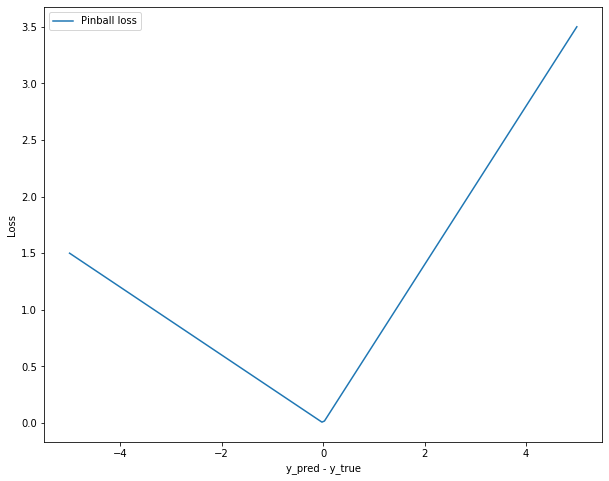

In [9]:
# visualize the pinball loss 
plt.figure(figsize=(10, 8))
tau = 0.7
x= np.linspace(-5,5,200) # x= y_pred - y_true
plt.plot(x,np.maximum(-(1-tau)*x,tau*x),label= "Pinball loss")
plt.xlabel('y_pred - y_true')
plt.ylabel('Loss')
plt.legend()

In [10]:
# define scoring function 

from sklearn.metrics import make_scorer

def loss(y_true, y_pred, tau=0.7): 
    return np.maximum(-(1-tau)*(y_pred-y_true),tau*(y_pred-y_true))

fan_loss = make_scorer(loss, greater_is_better=False) # scoring=fan_loss in cross_val_score

# Exploratory Data Analysis

In [6]:
X_df, y_df = train_data.drop(columns= ['Surplus']) ,train_data['Surplus']

In [7]:
train_data.count()

Year            501510
Month           501510
Day             501510
Hour            501510
Station ID      501510
Station Name    501510
Longitude       501510
Latitude        501510
Surplus         501510
Current Load    501510
dtype: int64

In [8]:
train_data.describe(include='all')

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus,Current Load
count,501510.000000,501510.000000,501510.000000,501510.00000,501510.000000,501510,501510.000000,501510.000000,501510.000000,501510.000000
unique,NaN,NaN,NaN,NaN,NaN,170,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,Grove St PATH,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,20557,NaN,NaN,NaN,NaN
mean,2017.120672,6.967175,15.755774,13.53116,3245.239120,NaN,-74.048257,40.724018,-0.003529,3686.857901
std,0.823187,3.232247,8.795023,5.68282,127.193682,NaN,0.011709,0.008850,3.716796,4736.941866
min,2016.000000,1.000000,1.000000,0.00000,127.000000,NaN,-74.083639,40.679331,-54.000000,-4674.000000
25%,2016.000000,4.000000,8.000000,9.00000,3195.000000,NaN,-74.052478,40.717733,-1.000000,1138.000000
50%,2017.000000,7.000000,16.000000,14.00000,3209.000000,NaN,-74.045953,40.723332,0.000000,2617.000000
75%,2018.000000,10.000000,23.000000,18.00000,3270.000000,NaN,-74.038914,40.727596,1.000000,4753.000000


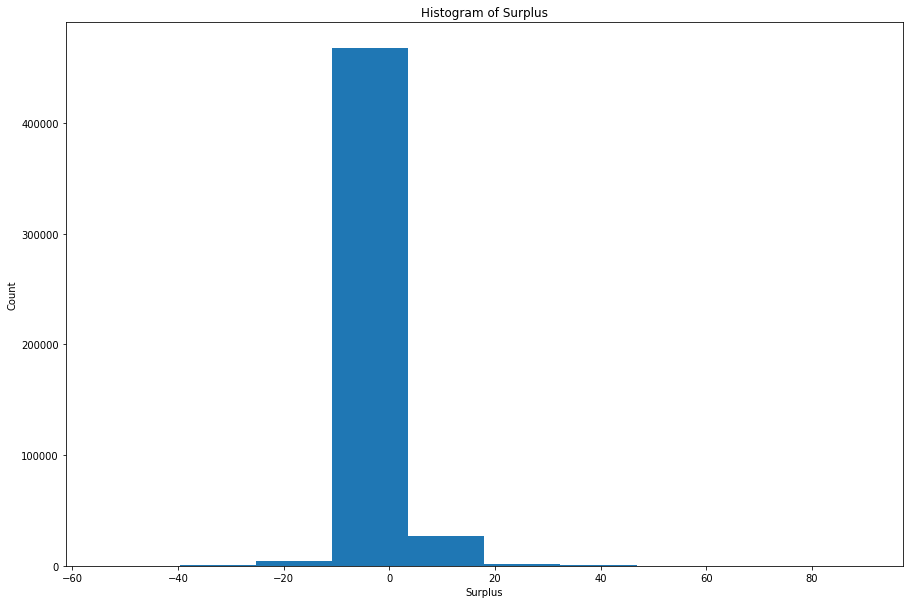

In [9]:
# Histogram
plt.figure(figsize=(15,10))
plt.hist(y_df)
plt.title('Histogram of Surplus')
plt.xlabel('Surplus')
plt.ylabel('Count')
plt.show()


Let's visualize the  visulazing the position of our docking stations in New York City:

In [51]:
train_data.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus,Current Load,Weekday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,1.0,1.0,4
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,0.0,0.0,4
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,2.0,2.0,4
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,-1.0,-1.0,4
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,2.0,3.0,4


In [52]:
#dockers coordinates 
coord=train_data[["Longitude", "Latitude"]]
coord2=coord.drop_duplicates(keep='first', inplace=False)  
coord2.shape

(184, 2)

In [53]:
map_1 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
coord2.reset_index(inplace = True, drop = True)
for i in range(len(coord2)):  
        long = coord2.loc[coord2.index ==i]['Longitude'].values[0]
        lati = coord2.loc[coord2.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  fill_color = '#FF3333',
                            number_of_sides = 8, radius = 5).add_to(map_1)

In [54]:
display(map_1)

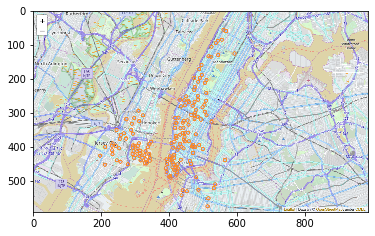

In [11]:
import cv2
img = cv2.imread("Data/Maps/map_1.png")
plt.imshow(img)

In [28]:
pos_surplus = train_data[train_data['Surplus']>0]   #215350
neg_surplus = train_data[train_data['Surplus']<0]   #222587
null_surplus = train_data[train_data['Surplus']==0] #63573

In [29]:
coord_pos=pos_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False) #184  
coord_neg=neg_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False)  #63
coord_null=null_surplus[["Longitude", "Latitude"]].drop_duplicates(keep='first', inplace=False) #63


In [49]:
map_2 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
map_3 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre
map_4 = folium.Map(location=[40.717937, -73.982155], zoom_start=12,tiles='OpenStreetMap') # manually added centre

coord_pos.reset_index(inplace = True, drop = True)
coord_neg.reset_index(inplace = True, drop = True)
coord_null.reset_index(inplace = True, drop = True)

    
for i in range(len(coord_null)):  
        long = coord_null.loc[coord_null.index ==i]['Longitude'].values[0]
        lati = coord_null.loc[coord_null.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  
                            number_of_sides = 6, radius = 4).add_to(map_2)
        
        
for i in range(len(coord_neg)):  
        long = coord_neg.loc[coord_neg.index ==i]['Longitude'].values[0]
        lati = coord_neg.loc[coord_neg.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long], 
                            number_of_sides = 5, radius = 3).add_to(map_4)
    
for i in range(len(coord_pos)):  
        long = coord_pos.loc[coord_pos.index ==i]['Longitude'].values[0]
        lati = coord_pos.loc[coord_pos.index ==i]['Latitude'].values[0]
        folium.RegularPolygonMarker([lati, long],  
                            number_of_sides = 5, radius = 3).add_to(map_3)


In [65]:
display(map_3)

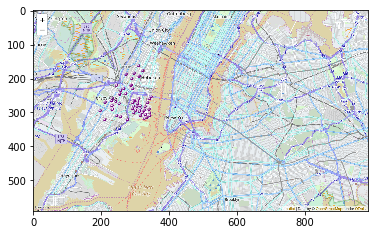

In [58]:
img_2 = cv2.imread("Data/Maps/map_2.png")
plt.imshow(img_2)


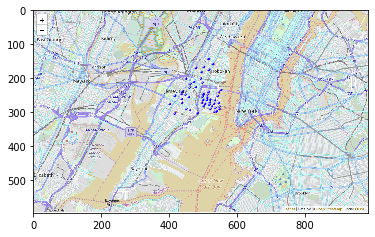

In [61]:
img_4 = cv2.imread("Data/Maps/map_4.png")
plt.imshow(img_4)

The dockers that tend to have negative or null surplus are located in Jersey City, which is another city that is 6.24 kms away from NYC. This can be interpreted as the following: people who work in New York might prefer to live in Jersey City (which is more affordable) and can therefore use the bikes to "travel" to New York (for work or other purposes), leading therefore to more bikes OUT than bikes IN, and hence a negative or null surplus. So it is important to be able to monitor the surplus so that people from that area continue to use bikes for their short trips.

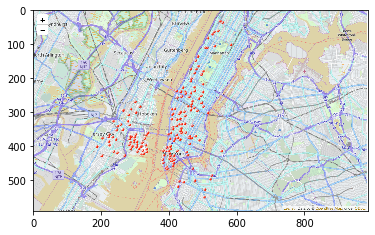

In [62]:
img_3 = cv2.imread("Data/Maps/map_3.png")
plt.imshow(img_3)

Here, we can see that the dockers are distributed across different districts of New York. These dockers tend to have positive surplus, which means that there are more bikes coming in than bikes leaving across Manhattan and Brooklyn. 

In [122]:
# Mean Surplus for a given station
df= train_data[['Surplus','Station ID']].groupby('Station ID').mean()
df.head()

,Surplus
Station ID,
127.0,1.0
128.0,1.0
146.0,1.0
157.0,1.0
161.0,1.0


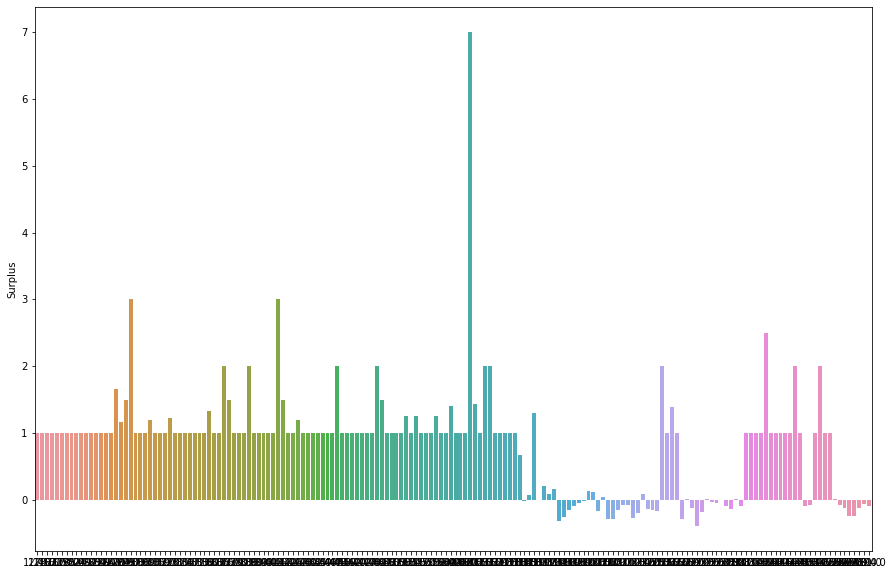

In [123]:
plt.figure(figsize=(15,10))
stations = list(df.index)
mean_surplus = df['Surplus']
sns.barplot(stations,mean_surplus)

In [124]:
df[df['Surplus']==7]

,Surplus
Station ID,
2021.0,7.0


In [125]:
train_data[train_data['Station ID']==2021] # We have the information for just 1 hour for this station 

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Surplus,Current Load
106179,2017.0,1.0,25.0,17.0,2021.0,W 45 St & 8 Ave,-73.988597,40.759291,7.0,7.0


In [126]:
# Mean Surplus for a given Hour 
df=train_data[['Surplus','Hour']].groupby('Hour').mean()
df.head()

,Surplus
Hour,
0.0,0.027257
1.0,0.011298
2.0,0.020746
3.0,0.035299
4.0,-0.015354


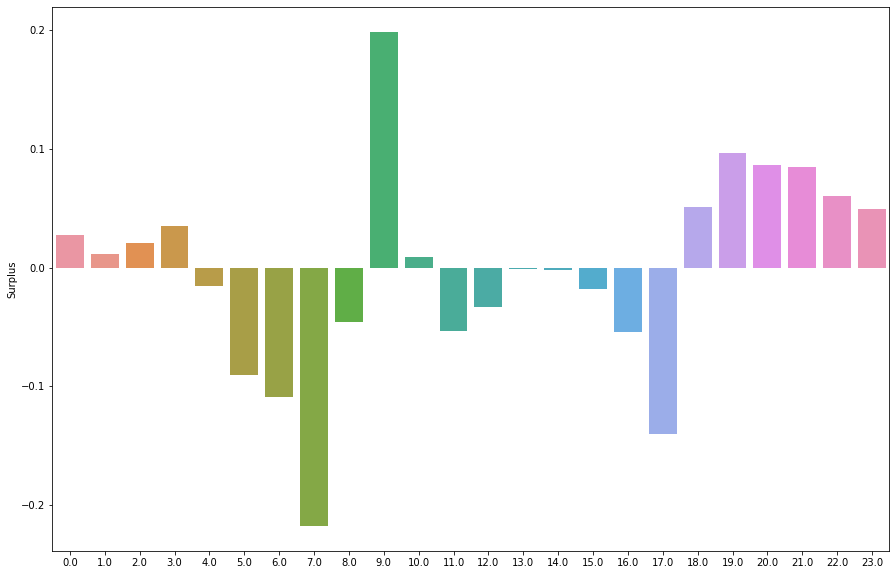

In [127]:
plt.figure(figsize=(15,10))
hour = list(df.index)
mean_surplus = df['Surplus']
sns.barplot(hour,mean_surplus)

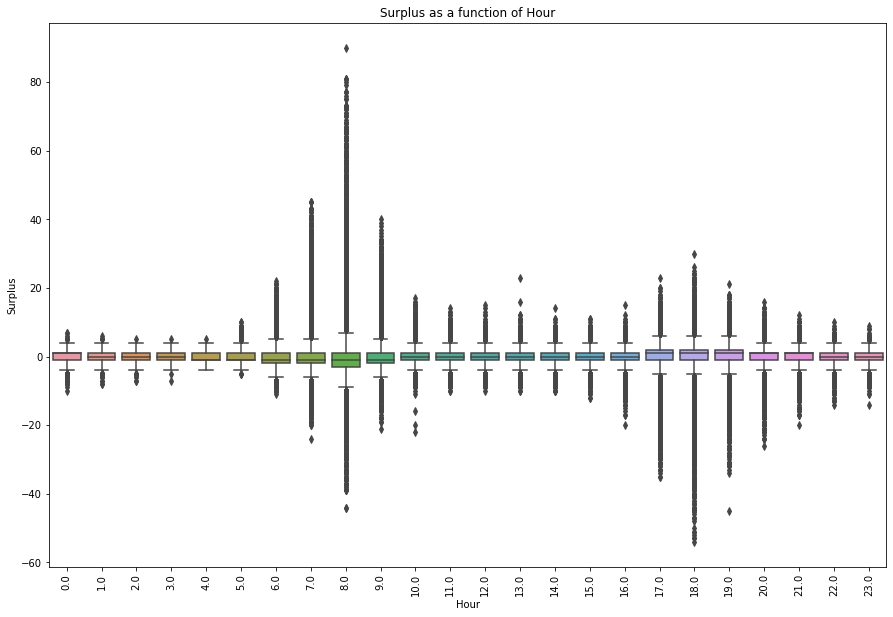

In [128]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Hour'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Hour')
plt.show()


## Weather Data

# Feature Engineering

## Day of week 

In [44]:
ts = pd.to_datetime(X_df[['Year','Month','Day']])
X_df['Weekdday']=ts.dt.weekday
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Current Load,Weekdday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,1.0,4
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,0.0,4
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,2.0,4
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,-1.0,4
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,3.0,4


In [45]:
## Groupby day of the week
train_data['Weekday'] = ts.dt.weekday 
df=train_data[['Surplus','Weekday']].groupby('Weekday').mean()
df.head()

,Surplus
Weekday,
0,-0.001843
1,-0.002161
2,-0.004565
3,-0.005144
4,-0.005566


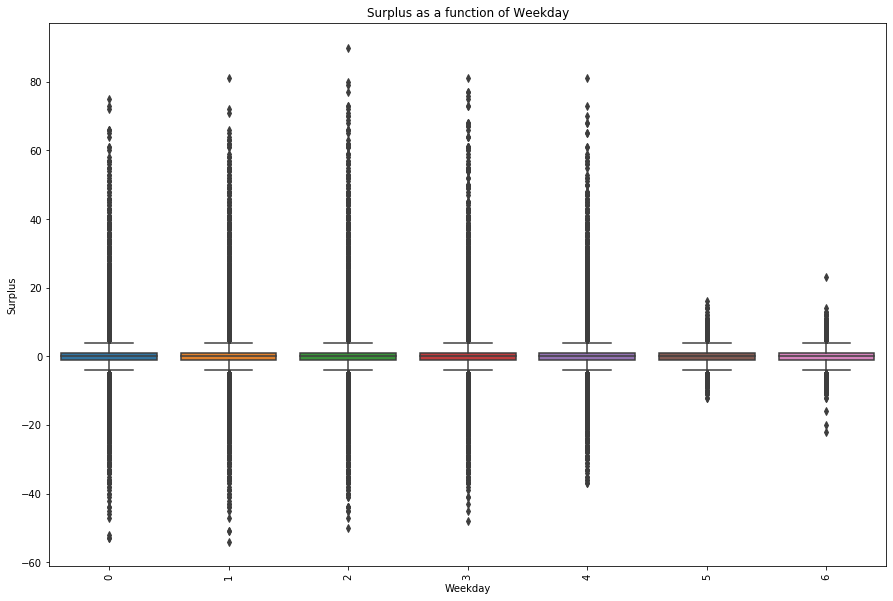

In [46]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Weekday'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Weekday')
plt.show()


In [47]:
pg=train_data.groupby(['Weekday','Hour']).mean()
pg.head()

Year     Month        Day   Station ID  Longitude  \
Weekday Hour                                                             
0       0.0   2017.055235  7.126958  15.732894  3244.070074 -74.047886   
        1.0   2016.984825  7.083460  15.851290  3240.069803 -74.048252   
        2.0   2016.930514  7.232628  16.235650  3243.474320 -74.049748   
        3.0   2017.107570  7.215139  15.541833  3239.135458 -74.051485   
        4.0   2017.081545  7.188841  16.354077  3237.302575 -74.048050   

               Latitude   Surplus  Current Load  
Weekday Hour                                     
0       0.0   40.723815  0.042869   4826.338005  
        1.0   40.723754  0.045524   5044.241275  
        2.0   40.724790 -0.018127   4742.009063  
        3.0   40.725281  0.035857   5441.147410  
        4.0   40.723005 -0.006438   5447.993562

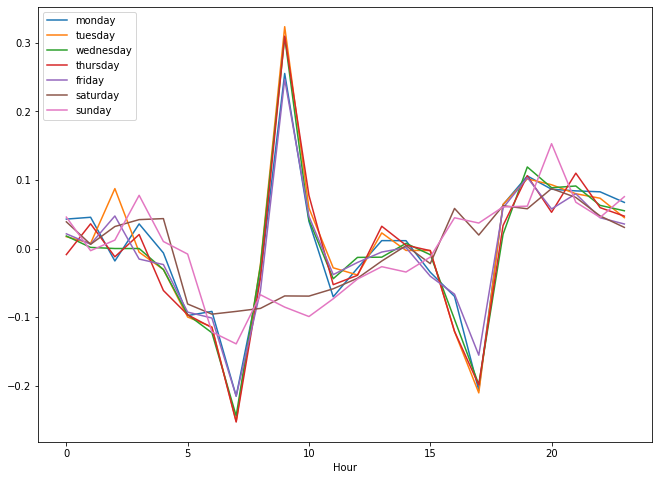

In [48]:
ax1 = plt.gca()
pg['Surplus'][0].plot(kind='line',ax=ax1,figsize=(11,8))
pg['Surplus'][1].plot(kind='line',ax=ax1)
pg['Surplus'][2].plot(kind='line',ax=ax1)
pg['Surplus'][3].plot(kind='line',ax=ax1)
pg['Surplus'][4].plot(kind='line',ax=ax1)
pg['Surplus'][5].plot(kind='line',ax=ax1)
pg['Surplus'][6].plot(kind='line',ax=ax1)
ax1.legend(['monday','tuesday','wednesday','thursday','friday','saturday','sunday'],loc='upper left')
plt.show()


Here it is interesting to notice that during weekdays (from Monday to Friday), we observe two negative pics at 7AM and at 6PM and two positive pics at 9AM and 7-8PM. This remark can be interpreted as the following: customers use massively the bikes drive to work early in the morning and head back home at the end of the afternoon. This use implies a big number of bikes out and a fewer number of bikes in in these hours, which explains the negative pics. On the other hand, people are expected to arrive at their work place between 9 and 10 AM and to their homes between 7 and 8 PM. Consequently the number of bikes in start to increase, leading to an increase in the surplus.

As far as the weekends are concerned, here we notice a flat distribution with more bikes used during the day.

## Holiday

Federal and State Holidays:
- New Year: 1 January.
- Martin Luther King Jr. Day: Third Monday of January. In honour of Martin Luther King Jr who fought to defend racial equality.
- President’s Day: Third Monday of February. Celebrated in honour of George Washington and all of United States’ Presidents.
- Memorial Day: Last Monday of May. To remember the soldiers who died while serving in the country’s armed forces.
- Independence Day: 4 July. On the 4 July, 1776, 13 colonies became independent from British domination and formed the first States of the country.
- Labor day: First Monday of September
- Columbus Day: Second Monday of October. Remembers Christopher Columbus’ arrival to the Americas on 12 October, 1492.
- Veterans Day: 11 November. The anniversary of the signing of the armistice.
- Thanksgiving Day: Last Thursday of November.
- Christmas: 25 December.


In [159]:
## add is_Holiday : 1 if holiday, else 0 
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal=calendar()
holidays = cal.holidays(start=ts.min(), end=ts.max()) # Holidays in the US
holidays

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-15', '2016-05-30',
               '2016-07-04', '2016-09-05', '2016-10-10', '2016-11-11',
               '2016-11-24', '2016-12-26', '2017-01-02', '2017-01-16',
               '2017-02-20', '2017-05-29', '2017-07-04', '2017-09-04',
               '2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25',
               '2018-01-01', '2018-01-15', '2018-02-19', '2018-05-28',
               '2018-07-04', '2018-09-03', '2018-10-08', '2018-11-12',
               '2018-11-22', '2018-12-25', '2019-01-01'],
              dtype='datetime64[ns]', freq=None)

In [182]:
X_df['Is_Holiday'] = ts.apply(lambda x: int(x in holidays))
X_df.head()

,Year,Month,Day,Hour,Station ID,Station Name,Longitude,Latitude,Weekdday,Is_Holiday
0,2016.0,1.0,1.0,0.0,3203.0,Hamilton Park,-74.044247,40.727596,4,1
1,2016.0,1.0,1.0,0.0,3209.0,Brunswick St,-74.050656,40.724176,4,1
2,2016.0,1.0,1.0,0.0,3213.0,Van Vorst Park,-74.047727,40.718489,4,1
3,2016.0,1.0,1.0,1.0,3187.0,Warren St,-74.038051,40.721124,4,1
4,2016.0,1.0,1.0,1.0,3203.0,Hamilton Park,-74.044247,40.727596,4,1


In [185]:
##Groupby is_holiday
train_data['Is_Holiday'] = ts.apply(lambda x: int(x in holidays))
df=train_data[['Surplus','Is_Holiday']].groupby('Is_Holiday').mean()
df

,Surplus
Is_Holiday,
0,0.000032
1,-0.001351


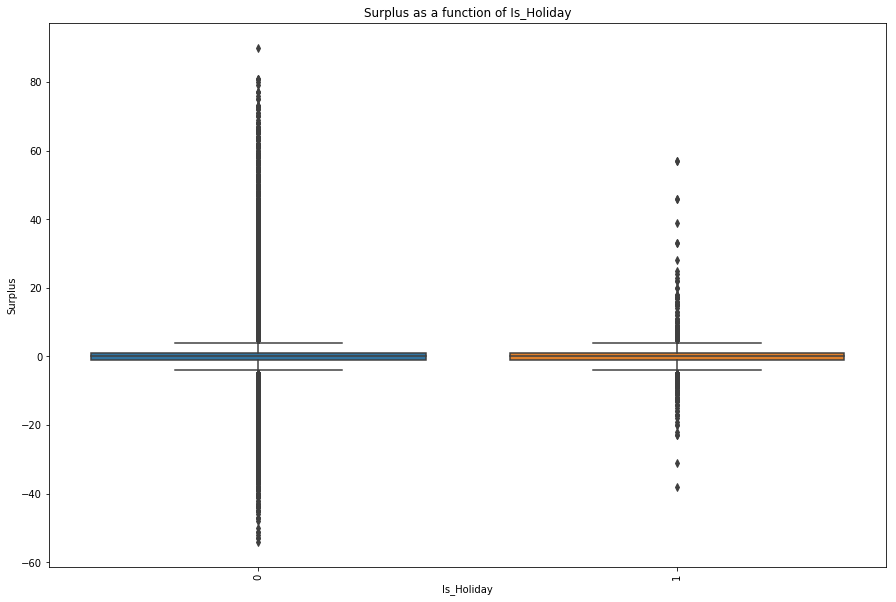

In [186]:
plt.figure(figsize=(15,10))
sns.boxplot(train_data['Is_Holiday'], train_data['Surplus'])
plt.xticks(rotation='vertical', )
plt.title('Surplus as a function of Is_Holiday')
plt.show()


# Predictions